# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 10: *MeanShift*
Tracks a region in an image by considering the colour histogram  
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadRGB, plotImageRGB, createImageF, createImageRGB
from PlotUtilities import plot3DHistogram
from ImageRegionsUtilities import densityHistogram, colourFeature
                         
# Math and iteration
from math import exp, sqrt
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageNames = Input image names
    histoSize = Size of the histogram
    initialPos = position of the region [column, row]
    sizeReg = Size of the region [column, row]
    sigma = weight control 

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter10/Input/")
imageNames = ["frame1.bmp", "frame2.bmp", "frame3.bmp", "frame4.bmp", "frame5.bmp", "frame6.bmp"]

histoSize = 64
initialPos = [100, 60]
sizeReg = [12, 18]
sigma  = 6.0

positions = [ ]
positions.append(initialPos)

### Read image and compute density

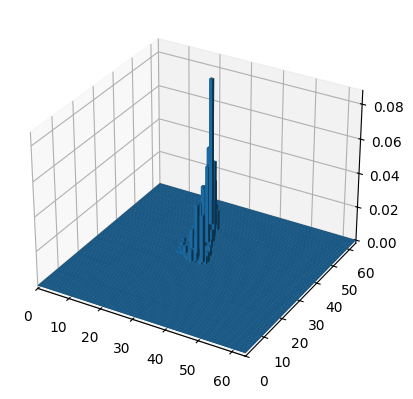

In [3]:
inputImage, width, height = imageReadRGB(pathToDir + imageNames[0])
q = densityHistogram(inputImage, positions[0], sizeReg, sigma, histoSize)
plot3DHistogram(q)

### Compute positions

In [4]:
# To store weights
weights = createImageF(2*sizeReg[0], 2*sizeReg[1])

# Avoid division by zero. Minimum value in the histogram
epsilon = 0.0000000001

# Quantization scale
colourScale = 256.0 / histoSize

# For each frame
numImages = len(imageNames)
for frameNum in range(1, numImages):
    
    inputImage, _, _ = imageReadRGB(pathToDir + imageNames[frameNum])

    currPos = [0, 0]
    newPos = positions[frameNum-1]
    while(currPos != newPos):
        # Histogram in current position
        currPos = newPos
        qs = densityHistogram(inputImage, currPos, sizeReg, sigma, histoSize)

        # Compute weights
        for deltaX, deltaY in itertools.product(range(-sizeReg[0],sizeReg[0]),   \
                                                range(-sizeReg[1], sizeReg[1])):
            # Position of the pixel in the image and in the weight array
            x, y = currPos[0] + deltaX, currPos[1] + deltaY
            px,py = deltaX+sizeReg[0], deltaY+sizeReg[1] 
            
            # The 2D colour description at this point. Scaled to fit the histogram values
            Cb,Cr= colourFeature(inputImage[y,x], colourScale)
              
            # Update weight considering original and current histogram values for the colour
            if qs[Cr, Cb] == 0:
                qs[Cr, Cb] = epsilon
            weights[py, px] = sqrt(q[Cr, Cb] / qs[Cr, Cb])
    
        # Compute mean shift sums
        meanSum = [0, 0]
        kernelSum = 0
        for deltaX, deltaY in itertools.product(range(-sizeReg[0],sizeReg[0]),   \
                                                range(-sizeReg[1], sizeReg[1])):
            # Position of the pixel in the image
            x, y = currPos[0] + deltaX, currPos[1] + deltaY 

            # Kernel parameter 
            w = exp(-(deltaX*deltaX + deltaY*deltaY)/(2*sigma*sigma));      

            # Weight index
            px, py = deltaX+sizeReg[0], deltaY+sizeReg[1]
   
            # Mean sum
            meanSum[0] += w * weights[py, px] * x
            meanSum[1] += w * weights[py, px] * y
        
            # Kernel sum
            kernelSum += w * weights[py, px]
        
        # Mean shift 
        newPos = [int(meanSum[0] / kernelSum), int(meanSum[1] / kernelSum)]
  
    positions.append(newPos);
#print(positions)

### Show results

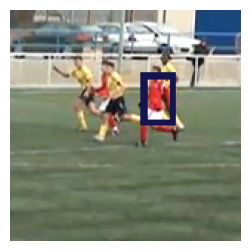

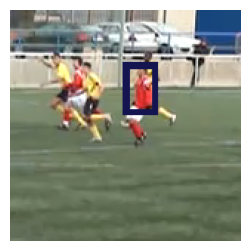

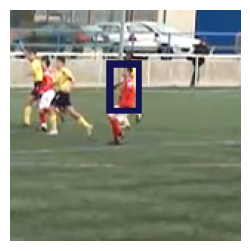

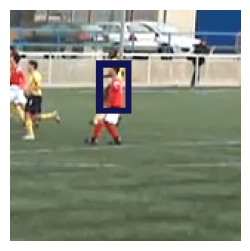

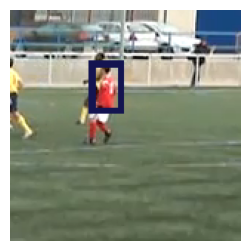

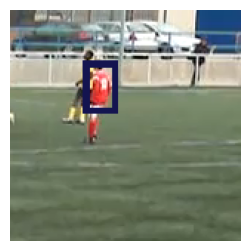

In [5]:
for frameNum in range(0, numImages):
    
    image, _, _ = imageReadRGB(pathToDir + imageNames[frameNum])
    p = positions[frameNum]
    borderDistance = [sizeReg[0] -5, sizeReg[1] -5]
    for x, y in itertools.product(range(p[0]-sizeReg[0], p[0]+sizeReg[0]), \
                                  range(p[1]-sizeReg[1], p[1]+sizeReg[1])):
        
        if abs(x-p[0]) > borderDistance[0] or abs(y-p[1]) > borderDistance[1]:
            image[y,x] = [20, 20, 80]
    
    plotImageRGB(image, figureSize = 3)
            